In [4]:
import intprim
from intprim.probabilistic_movement_primitives import *
import numpy as np
import matplotlib.pyplot as plt
# from intprim.util.kinematics import BaseKinematicsClass
import random
import pandas as pd
from frechetdist import frdist
from cem import CEM
# /home/zhiyuan/notebook_script/cem_promp
from utils import *

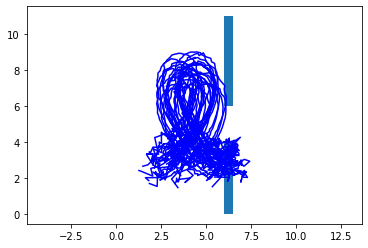

(30, 100, 2)


In [5]:
x = np.ones(20)*7
y1 = np.linspace(1,5,20)
y2 = np.linspace(6,9,20)
# y = np.hstack((y1,y2))


dataset= np.load('/home/zhiyuan/notebook_script/0930/l_shape.npy')
for i in range(30):
    plt.plot(dataset[i,:,0], dataset[i,:,1],'b-')
# plt.plot(x,y1,'r')
# plt.plot(x,y2,'r')
plt.gca().add_patch(plt.Rectangle((6,6),0.5,5))
plt.gca().add_patch(plt.Rectangle((6,0),0.5,4))
# plt.gca().add_patch(plt.Rectangle((-2,6),5,0.5))
# plt.gca().add_patch(plt.Rectangle((5,6),5,0.5))
# plt.gca().add_patch(plt.Rectangle((5,5),3,3))
    

# for i in range(t_cond.shape[0]):

#     plt.plot(q_cond[i,0], q_cond[i,1],  marker="o", markersize=5)

# plt.plot(3.7, 7.7,  marker="o", markersize=5)
plt.gca().axis("equal")  #ax.axis("equal") 
# plt.plot(q_cond[0,0], q_cond[0,1], "r", marker="o", markersize=5)
# plt.plot(mean_margs[0,50], mean_margs[1,50], "r", marker="o", markersize=5)
# plt.plot(q_cond[2,0], q_cond[2,1],"r", marker="o", markersize=5)
# mean_margs[:,50]
plt.show() 
print(dataset.shape)

<function matplotlib.pyplot.show(close=None, block=None)>

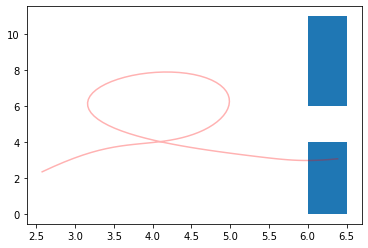

In [6]:
# promp
num_joints =2
# Create a ProMP with Gaussian basis functions.

basis_model = intprim.basis.GaussianModel(8, 0.1, ["x","y"])
promp = ProMP(basis_model)
Q = dataset.transpose(0,2,1)

# Add Demonstrations to the ProMP, which in turn calculates the list of weights for each demonstration.
for i in range(len(Q)):
	promp.add_demonstration(Q[i])

n_samples = 30# Number of trajectoies to sample
domain = np.linspace(0,1,100)

# sample some trajs
samples_learn= []
for i in range(n_samples):
    samples, _ = promp.generate_probable_trajectory(domain)
    samples_learn.append(samples)
samples_learn=np.array(samples_learn)  

# plot the sampled trajectories from proMP
# for i in range(samples_learn.shape[0]):   
#     plt.plot(samples_learn[i,0,:], samples_learn[i,1,:], 'g--', alpha=0.3)
# plt.show()

mean_margs = np.zeros(samples.shape)
upper_bound = np.zeros(samples.shape)
lower_bound = np.zeros(samples.shape)
stdqs = np.zeros(samples.shape)
for i in range(len(domain)):
    mu_marg_q, Sigma_marg_q = promp.get_marginal(domain[i])
    std_q = np.diagonal(Sigma_marg_q) ** 0.5
    stdqs[:,i] = std_q
    mean_margs[:,i] = mu_marg_q
    upper_bound[:,i] = mu_marg_q + std_q
    lower_bound[:,i] = mu_marg_q - std_q

plt.plot(mean_margs[0,:], mean_margs[1,:], 'r', alpha=0.3)

plt.gca().add_patch(plt.Rectangle((6,6),0.5,5))
plt.gca().add_patch(plt.Rectangle((6,0),0.5,4))
plt.show

In [8]:
mean_margs[:,50]

array([3.73612834, 7.7028387 ])

In [5]:
ref_x=get_normalization(mean_margs[0])
ref_x=get_normalization(mean_margs[1])              
ref_traj_T=np.array([ref_x,ref_x]).T 
limit_0 = np.array([[6,6.5],[6,11]])
limit_1 = np.array([[6,6.5],[0,4]])


In [6]:
# position with time
def get_reward(via_point):
    
    
    via_t= via_point[2]
#    first get the conditioned model
    old_promp=promp
    t_cond=np.array([via_t])
    q_cond =np.zeros([t_cond.shape[0],2])
    q_cond[0]=via_point[:2]
#     t_cond=np.array([0,via_t,99])
#     q_cond =np.zeros([t_cond.shape[0],2])
#     q_cond[0]= mean_margs[:,t_cond[0]]
#     q_cond[1]= via_point[:2]
#     q_cond[2]= mean_margs[:,t_cond[2]]

    mu_w_cond_rec, Sigma_w_cond_rec=old_promp.get_basis_weight_parameters()

    for i in range(t_cond.shape[0]):
        mu_w_cond_rec, Sigma_w_cond_rec = old_promp.get_conditioned_weights(domain[t_cond[i]], q_cond[i], mean_w=mu_w_cond_rec, var_w=Sigma_w_cond_rec)

    cond_traj = np.zeros([2,100])
    for i in range(len(domain)):
        mu_marg_q_con, Sigma_marg_q_con = promp.get_marginal(domain[i], mu_w_cond_rec, Sigma_w_cond_rec)
        cond_traj[:,i] = mu_marg_q_con
 

    col_0=  collision_detect(limit_0,cond_traj.T)
    col_1=  collision_detect(limit_1,cond_traj.T)
        
#     set reward = 1 if no collision
    if col_0 ==0 and col_1==0:
        reward = 1
    else:
        reward = 0
    
#     the output of col is 0 or 1
   
#     fre_dis= get_f_dist(ref_traj_T,cond_traj)
#     reward = -fre_dis  -10 *col

    return reward
    

In [7]:
# main
mu_0 = np.array([3.7,7.7,50])
sigma_0=  np.ones(2)*4
cem = CEM(get_reward, 2,mu_0 ,sigma_0)
v= cem.evalGaussian()
print(v, t,my_func(v))

IndexError: index 2 is out of bounds for axis 0 with size 2

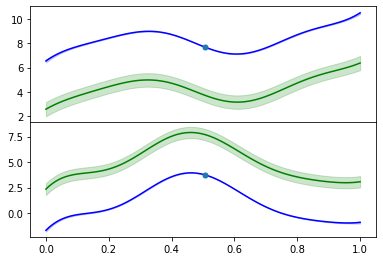

In [41]:
# multi via
t_cond=np.array([50])
q_cond =np.zeros([t_cond.shape[0],2])
# one obstacle
# q_cond[0]=np.array([2.32467629 , 9.3107627])
# two obstacles
# q_cond[0]=np.array([3.25786797, 8.13294368])
# end reward
q_cond[0]=np.array([7.71040462,3.75538285] )


# t_cond=np.array([0,50,99])
# q_cond =np.zeros([t_cond.shape[0],2])
# q_cond[0]= mean_margs[:,t_cond[0]]
# q_cond[1]= np.array([4.80748806, 4.55822106] )
# q_cond[2]= mean_margs[:,t_cond[2]]



# for i in range(t_cond.shape[0]):
#     q_cond[i] = mean_margs[:,t_cond[i]]+np.random.uniform(-1,1)

mu_w_cond_rec, Sigma_w_cond_rec=promp.get_basis_weight_parameters()

for i in range(t_cond.shape[0]):
    mu_w_cond_rec, Sigma_w_cond_rec = promp.get_conditioned_weights(domain[t_cond[i]], q_cond[i], mean_w=mu_w_cond_rec, var_w=Sigma_w_cond_rec)

samples_cond= []
for i in range(n_samples):
    samples, _ = promp.generate_probable_trajectory(domain, mu_w_cond_rec, Sigma_w_cond_rec)
    samples_cond.append(samples)

mean_margs_con = np.zeros(samples.shape)
upper_bound_con = np.zeros(samples.shape)
lower_bound_con = np.zeros(samples.shape)
for i in range(len(domain)):
	mu_marg_q_con, Sigma_marg_q_con = promp.get_marginal(domain[i], mu_w_cond_rec, Sigma_w_cond_rec)
	std_q_con = np.diagonal(Sigma_marg_q_con)** 0.5
	mean_margs_con[:,i] = mu_marg_q_con
	upper_bound_con[:,i] = mu_marg_q_con + std_q_con
	lower_bound_con[:,i] = mu_marg_q_con - std_q_con

fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4])
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4])

ax1.fill_between(domain, upper_bound_con[0], lower_bound_con[0], color = 'b', alpha=0.2)
ax1.plot(domain, mean_margs_con[0], 'b-')
ax1.fill_between(domain, upper_bound[0], lower_bound[0], color = 'g', alpha=0.2)

ax1.plot(domain, mean_margs[0], 'g-')


for i in range(t_cond.shape[0]):
    ax1.plot(domain[t_cond[i]], q_cond[i,0],  marker="o", markersize=5)

ax2.fill_between(domain, upper_bound_con[1], lower_bound_con[1], color = 'b', alpha=0.2)
ax2.plot(domain, mean_margs_con[1], 'b-')
for i in range(t_cond.shape[0]):
    ax2.plot(domain[t_cond[i]], q_cond[i,1],  marker="o", markersize=5)

ax2.fill_between(domain, upper_bound[1], lower_bound[1], color = 'g', alpha=0.2)
ax2.plot(domain, mean_margs[1], 'g-')

<function matplotlib.pyplot.show(close=None, block=None)>

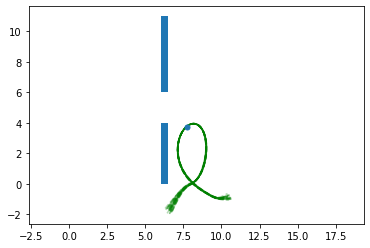

In [43]:
samples_cond=np.array(samples_cond) 
for i in range(samples_cond.shape[0]):
    plt.plot(samples_cond[i,0,:100], samples_cond[i,1,:100], 'g--', alpha=0.3)
    

for i in range(t_cond.shape[0]):

    plt.plot(q_cond[i,0], q_cond[i,1],  marker="o", markersize=5)
    
plt.gca().add_patch(plt.Rectangle((6,6),0.5,5))
plt.gca().add_patch(plt.Rectangle((6,0),0.5,4))
# plt.gca().add_patch(plt.Rectangle((5,5),3,3))
plt.gca().axis("equal")  #ax.axis("equal") 
plt.show

In [ ]:
[7.71040462 3.75538285] 1.0207069312706893